# Melodic Expectation with Recurrent Neural Networks

In this notebook we will explore how to compute musical expectation with Recurrent Neural Networks (RNNs).

RNNs are a family of neural networks designed to model sequential data (like music!).

In [19]:
import glob
import logging
import os

import numpy as np
import partitura
import torch

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)
# Define seed for random number generator
RNG = np.random.RandomState(42)


## Preparing the data
We can load the data and compute the features

In [21]:
from rnn import load_data

# To filter out short melodies The minimum number of notes that a sequence should have
min_seq_len = 10
sequences = load_data(min_seq_len)

INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.

INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.

INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.

In [3]:
# Decide which features to use
# Useful info
field_names = [
    "pitch", 
    "onset_sec", 
    "duration_sec"
]

def get_features(seq):
    # Possible things to try:
    # * Use inter onset interval (IOI) instead of duration
    # * Code rest (and duration) instead of IOI
    feature_names = [
        "pitch",
        "duration_sec"
    ]
    
    # construct features
    x = np.column_stack([seq[fn] for fn in feature_names])
    return x

Data = [get_features(x) for x in sequences]

# MIDIs were generated at 100bpm
dur_encoder = OneHotEncoder().fit(np.hstack([np.round(x[:, 1] * 100 / 60, 3) for x in Data]).reshape(-1, 1))
pitch_encoder = OneHotEncoder().fit(np.hstack([x[:, 0] for x in Data]).reshape(-1, 1))

data_one_hot = []
for x in Data:
    pitch_features = pitch_encoder.transform(x[:, 0].reshape(-1, 1)).toarray()
    duration_features = dur_encoder.transform(np.round(x[:, 1] * 100 / 60 , 3).reshape(-1, 1)).toarray()
    data_one_hot.append(np.column_stack([pitch_features, duration_features]))
    
input_size = data_one_hot[0].shape[1]
pitch_idxs = np.arange(len(pitch_encoder.categories_[0]))
dur_idxs = np.arange(len(pitch_encoder.categories_[0]), len(pitch_encoder.categories_[0]) + len(dur_encoder.categories_[0]))

We can model musical expectation as a supervised learning problem, by training a model to predict the next event in the sequence.

Ideally, we would like our data handling code to be decoupled from the model definition and training. PyTorch provides a convenient way to handle data with the `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes.

* `Dataset` stores the samples and their corresponding targets
* `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

We can create a custom `Dataset` for our musical data. A custom `Dataset` class must implement three functions: `__init__`, `__len__`, and `__getitem__`.

In our case, we would like a dataset for which the inputs would be sequences of length $S$

$$ \mathbf{X} = \{\mathbf{x_i}, \dots, \mathbf{x}_{i + S}\}$$

and their corresponding targets are a one-step shifted version of the inputs, i.e.,

$$ \mathbf{Y} = \{\mathbf{x}_{i+1}, \dots, \mathbf{x}_{i + S + 1}\}$$

We can define such a dataset with the following `PieceDataset` class:

In [4]:
class PieceDataset(Dataset):
    """
    Dataset for sequential predictions.
    In this case, if data is a sequence of datapoints,
    the inputs (x) will be x[t:t+seq_len] and outputs would
    be (y) x[t+1:t+seq_len+1] (i.e., the next events)
    """
    def __init__(self, data, seq_len=min_seq_length):
        self.data = data
        self.seq_len = seq_len
        
    @property
    def piecewise(self):
        return self.seq_len == -1

    def __getitem__(self, i):
        if self.piecewise:
            return self._get_item_piecewise(i)
        else:
            return self._get_item_sequencewise(i)

    def _get_item_piecewise(self, i):
        if i > 0:
            raise IndexError
        x = self.data[:-1]
        y = self.data[1:]
        return x, y

    def _get_item_sequencewise(self, i):
        if i + self.seq_len - 1 > len(self.data):
            raise IndexError
        x = self.data[i:i + self.seq_len]
        y = self.data[i + 1: i + self.seq_len + 1]
        return x, y

    def __len__(self):
        if self.piecewise:
            return 1
        else:
            return max(0, len(self.data) - self.seq_len)

In [5]:
class RecurrentModel(nn.Module):
    """
    A Simple Recurrent Model
    """

    def __init__(self,
                 input_size,
                 recurrent_size, hidden_size,
                 n_layers=1, dropout=0.0,
                 batch_first=True,
                 dtype=torch.float32,
                 rnn_layer=nn.LSTM,
                 device=None):
        nn.Module.__init__(self)
        self.input_size = input_size
        self.recurrent_size = recurrent_size
        self.hidden_size = hidden_size
        self.output_size = input_size
        self.n_layers = n_layers
        self.batch_first = batch_first
        self.device = device if device is not None else torch.device('cpu')
        self.to(self.device)
        self.dtype = dtype
        self.rnn = rnn_layer(input_size, 
                             self.recurrent_size,
                             self.n_layers,
                             batch_first=batch_first, 
                             dropout=dropout,
                             bidirectional=False)
        dense_in_features = self.recurrent_size
        self.dense = nn.Linear(in_features=dense_in_features,
                               out_features=self.hidden_size)
        self.output = nn.Linear(in_features=self.hidden_size,
                                out_features=self.output_size)

    def init_hidden(self, batch_size):
        
        if isinstance(self.rnn, nn.LSTM):
            h0 = torch.zeros(self.n_layers, batch_size, self.recurrent_size).to(self.dtype)
            c0 = torch.zeros(self.n_layers, batch_size, self.recurrent_size).to(self.dtype)
            return (h0, c0)
        else:
            return torch.zeros(self.n_layers, batch_size, self.recurrent_size).to(self.dtype)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h0 = self.init_hidden(batch_size)
        output, h = self.rnn(x, h0)
        flatten_shape = self.recurrent_size
        dense = self.dense(output.contiguous().view(-1, flatten_shape))
        y = self.output(dense)
        y = y.view(batch_size, seq_len, self.output_size)

        return y
    
rnn = RecurrentModel(input_size=input_size, recurrent_size=64, hidden_size=64, n_layers=1)


def prob_xtp1(rnn, x, pitch_idxs=pitch_idxs, dur_idxs=dur_idxs):
    # Assume that batch_size == 1, i.e., there is only one
    # sequence
    softmax = nn.SoftMax(dim=0)
    y = rnn(x)[-1, 1]
    pitch_prob = softmax(y[pitch_idxs])
    duration_prob = softmax(y[dur_idxs])

    return pitch_prob, duration_prob


In [6]:
class PitchDurationCrossEntropyLoss(nn.Module):
    """
    Cross Entropy of Pitch and Duration
    """
    def __init__(self, pitch_idxs, dur_idxs, weights=[0.5, 0.5], name='PitchDurationCrossEntropyLoss'):
        nn.Module.__init__(self)
        self.pitch_idxs = pitch_idxs
        self.dur_idxs = dur_idxs    
        self.weights = weights
        self.name = name
        self.ce = nn.CrossEntropyLoss()

    def __call__(self, predictions, targets):
        pitch_preds = predictions[:, :, self.pitch_idxs]
        pitch_preds = pitch_preds.view(-1, pitch_preds.size(2))
        dur_preds = predictions[:, :, self.dur_idxs]
        dur_preds = dur_preds.view(-1, dur_preds.size(2))
        pitch_target = targets[:, :, self.pitch_idxs].argmax(-1).view(-1).to(torch.long)
        dur_target = targets[:, :, self.dur_idxs].argmax(-1).view(-1).to(torch.long)
        loss = (self.weights[0] * self.ce(pitch_preds, pitch_target) + 
                self.weights[1] * self.ce(dur_preds, dur_target))
        return loss


In [7]:
# The dataset will be the concatenation of the datasets for each piece
dataset = ConcatDataset([PieceDataset(piece, seq_len=-1) for piece in data_one_hot])

# Select training, test and validation sets
dataset_idx = np.arange(len(dataset))

valid_size = 0.2
test_size = 0.3
batch_size = 1

trainvalid_idx, test_idx = train_test_split(dataset_idx, 
                                            test_size=0.33,
                                            random_state=RNG)

RNG.shuffle(trainvalid_idx)
len_valid = int(np.round(len(dataset) * valid_size))
valid_idx = dataset_idx[0:len_valid]
train_idx = dataset_idx[len_valid:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

We can now setup the training of the model!

The `SupervisedTrainer` class is a helper to setup a function to train a model in a supervised way.

**Try changing a couple settings**

* Adjusting learning rate
* Selecting an Optimizer (see [torch.optim](https://pytorch.org/docs/stable/optim.html?highlight=optimization))

In [12]:
from rnn import SupervisedTrainer

train_loss = PitchDurationCrossEntropyLoss(pitch_idxs, dur_idxs, name="Train")
valid_loss = PitchDurationCrossEntropyLoss(pitch_idxs, dur_idxs, name="Validation")
learning_rate = 0.01
epochs = 10
early_stopping = 2

optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

trainer = SupervisedTrainer(model=rnn,
                            train_loss=train_loss,
                            valid_loss=valid_loss,
                            train_dataloader=train_loader,
                            valid_dataloader=valid_loader,
                            epochs=epochs,
                            save_freq=1, # This parameter controlls how often the model is validated
                            early_stopping=early_stopping,
                            optimizer=optimizer)

Now we are ready to train the model!

In [16]:
trainer.train()

INFO:rnn:Saving current best: ./best_model.pth ...
epoch: 1/10 loss: 1.81: 100%|██████████| 137/137 [00:06<00:00, 20.39it/s]
INFO:rnn:Epoch:0	Train 1.855	Validation 1.930
INFO:rnn:Saving checkpoint: ./checkpoint-epoch-0.pth ...
INFO:rnn:Saving current best: ./best_model.pth ...
epoch: 2/10 loss: 1.81: 100%|██████████| 137/137 [00:06<00:00, 20.38it/s]
INFO:rnn:Epoch:1	Train 1.839	Validation 1.931
INFO:rnn:Saving checkpoint: ./checkpoint-epoch-1.pth ...
epoch: 3/10 loss: 1.88: 100%|██████████| 137/137 [00:06<00:00, 20.43it/s]
INFO:rnn:Epoch:2	Train 1.805	Validation 1.907
INFO:rnn:Saving checkpoint: ./checkpoint-epoch-2.pth ...
INFO:rnn:Saving current best: ./best_model.pth ...
epoch: 4/10 loss: 1.66: 100%|██████████| 137/137 [00:06<00:00, 20.42it/s]
INFO:rnn:Epoch:3	Train 1.809	Validation 1.909
INFO:rnn:Saving checkpoint: ./checkpoint-epoch-3.pth ...
epoch: 5/10 loss: 1.63: 100%|██████████| 137/137 [00:06<00:00, 20.45it/s]
INFO:rnn:Epoch:4	Train 1.769	Validation 1.892
INFO:rnn:Saving che

It is useful to have a look at the training curves. Since ANNs are prone to overfitting, comparing the behavior of the training loss and the validation loss can be very useful.

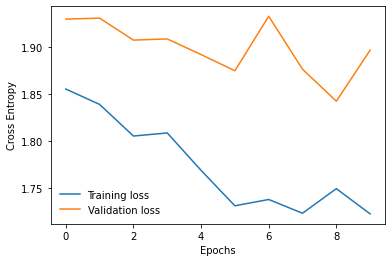

In [17]:
train_loss_fn = os.path.join(".", "train_loss.txt")
train_loss = np.loadtxt(train_loss_fn)
valid_loss_fn = os.path.join(".", "valid_loss.txt")
valid_loss = np.loadtxt(valid_loss_fn)
plt.plot(train_loss[:, 0], train_loss[:, 1], label="Training loss")
plt.plot(valid_loss[:, 0], valid_loss[:, 1], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy")
plt.legend(frameon=False)

In [18]:
def eval_model(model, test_loader, loss=valid_loss):
    test_ce = []
    model.eval()
    for i, (x, y) in enumerate(test_loader):
        preds = model(x.to(model.dtype))
        ce = vloss(preds, y)
        test_ce.append(ce.item())
        
    return np.mean(test_ce)

**Exercise**

Define and train 2 different models. You can decide on the architecture and the optimization.

Compare the performance of both models